# Neural Classification

### Fake News Corpus

For this example the data is from https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset.

In [1]:
import pandas as pd

news_fake = pd. read_csv('/Users/cindy/Corpora/Fake.csv') #my path
news_fake.insert(0, 'label', 0)
news_true = pd.read_csv('/Users/cindy/Corpora//True.csv') #my path
news_true.insert(0, 'label', 1)
news_df = pd.concat([news_true, news_fake], ignore_index=True)
news_df.head()

,label,title,text,subject,date
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,1,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,1,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,1,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


## Import Tensorflow

In [2]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)

Version:  2.4.1
Eager mode:  True
Hub version:  0.12.0


## Split into to testing and training set

We're using sci kit learns's [test_train_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

In [3]:
from sklearn.model_selection import train_test_split

train_examples, test_examples, train_labels, test_labels = train_test_split(news_df['text'], news_df['label'], test_size = 0.2, random_state=0)

In [4]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 35918, test entries: 8980


In [5]:
train_examples[:10]

38388    Thank God America has people like Ted Cruz in ...
23136    Donald Trump is not fit to be president. Most ...
24221    With Donald Trump writing Executive Orders tha...
8837     WASHINGTON (Reuters) - Democrat Bernie Sanders...
15902    WASHINGTON (Reuters) - A rare high-level defec...
41472    When multi-millionaire San Francisco 49ers qua...
649      WASHINGTON (Reuters) - U.S. Attorney General J...
31830    President Trump s deputy assistant Sebastian G...
10996    WASHINGTON (Reuters) - A political fight over ...
13761    SOFIA (Reuters) - The Bulgarian Orthodox Churc...
Name: text, dtype: object

In [6]:
train_labels[:10]

38388    0
23136    0
24221    0
8837     1
15902    1
41472    0
649      1
31830    0
10996    1
13761    1
Name: label, dtype: int64

## Create the embedding vector

This example uses a pre-trained text embedding as the first layer, which will has two advantages:
- we don't have to worry about text preprocessing,
- we can benefit from transfer learning.

For this example we will use a model from [TensorFlow Hub](https://www.tensorflow.org/hub) called `google/nnlm-en-dim128-with-normalization/2`.  This is a larger model with additional text normalization to remove punctuation and an embedding dimension of 128.

In [7]:
model = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 128), dtype=float32, numpy=
array([[ 2.22976112e+00,  3.28908265e-02,  1.40641928e-01,
         6.44701198e-02,  5.91396280e-02, -1.00054406e-01,
         2.91841805e-01, -5.20529449e-01, -4.86851484e-01,
        -1.16212003e-01,  4.71871138e-01, -2.44435564e-01,
        -4.77778018e-01, -4.93724465e-01, -2.86798239e-01,
         1.46333113e-01, -4.99941498e-01, -4.89518493e-02,
        -2.52657712e-01,  1.49594021e+00,  8.28611702e-02,
         9.33884308e-02, -4.53871280e-01, -3.39736998e-01,
         2.62019157e-01, -7.54148588e-02,  3.68622482e-01,
         3.43239605e-01,  6.98358193e-02,  2.31160909e-01,
        -1.33078456e-01,  1.36219516e-01,  3.73210222e-01,
        -9.24271420e-02,  2.66868711e-01, -2.12127455e-02,
        -3.42397779e-01, -1.37694359e-01, -3.22433710e-02,
         3.77818793e-01,  2.19719857e-01, -5.66109233e-02,
        -3.37439090e-01, -2.56070346e-01,  4.45034839e-02,
         2.48606458e-01, -2.28736237e-01, -3.99297625e-02,
      

## Build the model

In [8]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 124,644,769
Trainable params: 124,644,769
Non-trainable params: 0
_________________________________________________________________


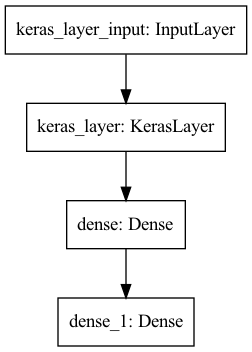

In [17]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model, to_file='model.png', show_layer_names=True)

### Loss Function and Optimizer

In [10]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

### Validation Set

In [11]:
x_val = train_examples[:31500]
partial_x_train = train_examples[31500:]

y_val = train_labels[:31500]
partial_y_train = train_labels[31500:]

## Train the Model

In [12]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
9/9 [==============================] - 11s 1s/step - loss: 0.6702 - accuracy: 0.5345 - val_loss: 0.5418 - val_accuracy: 0.7012
Epoch 2/40
9/9 [==============================] - 10s 1s/step - loss: 0.5036 - accuracy: 0.8048 - val_loss: 0.4160 - val_accuracy: 0.9142
Epoch 3/40
9/9 [==============================] - 10s 1s/step - loss: 0.3733 - accuracy: 0.9354 - val_loss: 0.3134 - val_accuracy: 0.9403
Epoch 4/40
9/9 [==============================] - 10s 1s/step - loss: 0.2682 - accuracy: 0.9590 - val_loss: 0.2388 - val_accuracy: 0.9509
Epoch 5/40
9/9 [==============================] - 10s 1s/step - loss: 0.1887 - accuracy: 0.9734 - val_loss: 0.1864 - val_accuracy: 0.9607
Epoch 6/40
9/9 [==============================] - 10s 1s/step - loss: 0.1349 - accuracy: 0.9822 - val_loss: 0.1522 - val_accuracy: 0.9665
Epoch 7/40
9/9 [==============================] - 10s 1s/step - loss: 0.0958 - accuracy: 0.9908 - val_loss: 0.1275 - val_accuracy: 0.9712
Epoch 8/40
9/9 [==================

## Evaluate the model

In [13]:
results = model.evaluate(test_examples, test_labels)
results

281/281 [==============================] - 2s 5ms/step - loss: 0.0622 - accuracy: 0.9806


[0.06216132268309593, 0.9806236028671265]

### Create a graph of accuracy and loss over time

In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

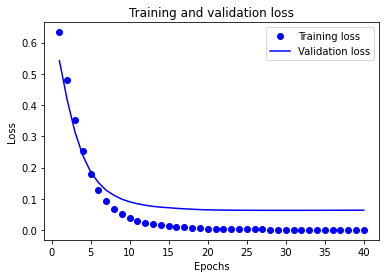

In [15]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

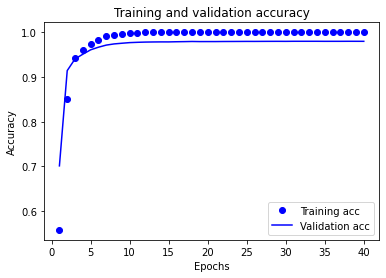

In [16]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Ref: https://www.tensorflow.org/hub/tutorials/tf2_text_classification